## Importing Libraries

In [2]:
# For data preprocessing
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# To build visualizations
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns


## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Project/store-sales-time-series-forecasting

/content/drive/My Drive/Colab Notebooks/Project/store-sales-time-series-forecasting


In [ ]:
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv")
holidays_events = pd.read_csv("holidays_events.csv")
test = pd.read_csv("test.csv")

In [ ]:
#Merge train data for analysis and modeling
train = train.merge(stores, how="left", on='store_nbr')   
train = train.merge(oil, how="left", on='date')      
train = train.merge(transactions, how="left", on=['date','store_nbr'])  
train = train.merge(holidays_events,on='date',how='left')
train = train.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

#Merge test data for analysis and modeling
test = test.merge(stores, how="left", on='store_nbr')   
test = test.merge(oil, how="left", on='date')      
test = test.merge(holidays_events,on='date',how='left')
test = test.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

In [ ]:
dup = train[train.duplicated(subset=train.columns.tolist(), keep=False)]
print(f"Duplicate records in train: {dup.shape[0]}")

dup = test[test.duplicated(subset=test.columns.tolist(), keep=False)]
print(f"Duplicate records in test: {dup.shape[0]}")

Duplicate records in train: 0
Duplicate records in test: 0


In [ ]:
common_df = pd.merge(
    train,
    test,
    how='inner',
    on=test.columns.tolist()
)

print(f"Leakage records: {common_df.shape[0]}")
common_df.head()

Leakage records: 0


,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,locale,locale_name,description,transferred


## Missing Values Handling

### 1.1 Oil Price

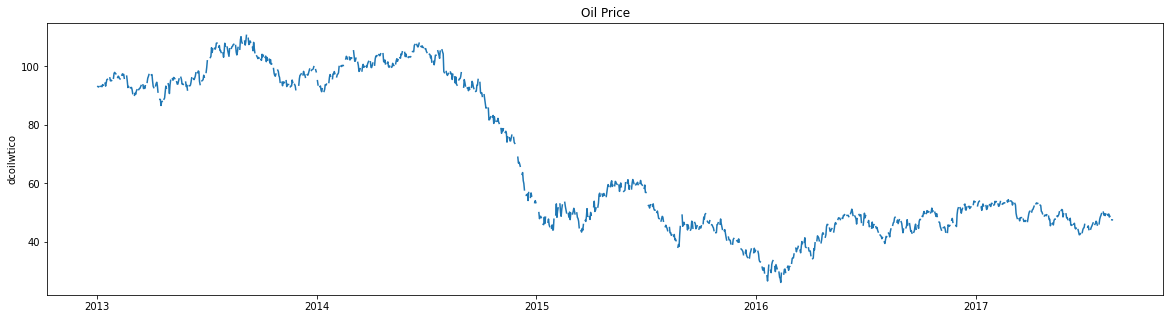

In [ ]:
train['date'] = pd.to_datetime(train['date'])
oil_mis = train.set_index("date").dcoilwtico.resample("D").mean().reset_index()
plt.rcParams['figure.figsize'] = (20, 5)
plt.title('Oil Price')
plt.ylabel('dcoilwtico')
plt.plot(oil_mis['date'],oil_mis['dcoilwtico']);

In [ ]:
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='bfill')
test['dcoilwtico'] = test['dcoilwtico'].fillna(method='bfill')

### 1.2 Transactions

In [ ]:
train.transactions = train.transactions.replace(np.nan,0)

### 1.3 Holiday Events

In [ ]:
train[['locale','locale_name', 'description']] = train[['locale','locale_name', 'description']].replace(np.nan,'')
train['holiday_type'] = train['holiday_type'].replace(np.nan,'Work Day')
train['transferred'] = train['transferred'].replace(np.nan,False)

test[['locale','locale_name', 'description']] = test[['locale','locale_name', 'description']].replace(np.nan,'')
test['holiday_type'] = test['holiday_type'].replace(np.nan,'Work Day')
test['transferred'] = test['transferred'].replace(np.nan,False)

# Feature Engineering

## Extracting date information

In [ ]:
#Exctracting date information from train data
train['date'] = pd.to_datetime(train['date'])
train['Quarter'] = train['date'].apply(lambda x: pd.to_datetime(x).quarter)
train['Week'] = train['date'].apply(lambda x: pd.to_datetime(x).week)
train['DayofWeek'] = train['date'].apply(lambda x: pd.to_datetime(x).dayofweek)
train['isWeekend'] = np.where(train['DayofWeek'].isin([5,6]),1,0)
train['Month'] = train['date'].apply(lambda x: pd.to_datetime(x).month)
train['Year'] = train['date'].apply(lambda x: pd.to_datetime(x).year)
train['Day'] = train['date'].apply(lambda x: pd.to_datetime(x).day)
train['season'] = train['Month'].apply(lambda x: 0 if x in [2,3] else 1 if x in [4,5,6] else 2 if x in [7,8] else 3 if x in [9,10,11] else 4)

#Exctracting date information from test data
test['date'] = pd.to_datetime(train['date'])
test['Quarter'] = test['date'].apply(lambda x: pd.to_datetime(x).quarter)
test['Week'] = test['date'].apply(lambda x: pd.to_datetime(x).week)
test['DayofWeek'] = test['date'].apply(lambda x: pd.to_datetime(x).dayofweek)
test['isWeekend'] = np.where(test['DayofWeek'].isin([5,6]),1,0)
test['Month'] = test['date'].apply(lambda x: pd.to_datetime(x).month)
test['Year'] = test['date'].apply(lambda x: pd.to_datetime(x).year)
test['Day'] = test['date'].apply(lambda x: pd.to_datetime(x).day)
test['season'] = test['Month'].apply(lambda x: 0 if x in [2,3] else 1 if x in [4,5,6] else 2 if x in [7,8] else 3 if x in [9,10,11] else 4)

In [ ]:
#Created a new feature, the length of the day leading to thanksgiving and christmas on train data
train['Days_to_Thansksgiving'] = (pd.to_datetime(train["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(train["date"], format="%Y-%m-%d")).dt.days.astype(int)
train['Days_to_Christmas'] = (pd.to_datetime(train["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(train["date"], format="%Y-%m-%d")).dt.days.astype(int)

#Created a new feature, the length of the day leading to thanksgiving and christmas on test data
test['Days_to_Thansksgiving'] = (pd.to_datetime(test["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(test["date"], format="%Y-%m-%d")).dt.days.astype(int)
test['Days_to_Christmas'] = (pd.to_datetime(test["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(test["date"], format="%Y-%m-%d")).dt.days.astype(int)

## Data Encoding

In [ ]:
#Encoding store type column to an ordinal feature based on sales
storetype_values = {'A':5, 'D':4, 'B':3, 'E':2, 'C':1}
train['store_type'] = train.store_type.map(storetype_values)
test['store_type'] = test.store_type.map(storetype_values)

#Encoding holiday type column to an ordinal feature based on sales
holidaytype_values = {'Additional':6, 'Transfer':5, 'Bridge':4, 'Event':3, 'Holiday':2, 'Work Day':1}
train['holiday_type'] = train.holiday_type.map(holidaytype_values)
test['holiday_type'] = test.holiday_type.map(holidaytype_values)

#Encoding locale column to an ordinal feature based on sales
locale_values = {'National':4, 'Regional':3, 'Local':2, '':1}
train['locale'] = train.locale.map(locale_values)
test['locale'] = test.locale.map(locale_values)

In [ ]:
#Label encoding on categorical data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
feature = ['family','city','state','locale_name','transferred']
train[feature] = train[feature].apply(le.fit_transform)
test[feature] = test[feature].apply(le.fit_transform)

In [ ]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'dcoilwtico', 'transactions',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'Quarter', 'Week', 'DayofWeek', 'isWeekend', 'Month', 'Year', 'Day',
       'season', 'Days_to_Thansksgiving', 'Days_to_Christmas'],
      dtype='object')

## Modelling (Regression)

In [3]:
#Import ML Algorithms
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
import pandas.util.testing as tm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

In [ ]:
model_features = ['store_nbr', 'family', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'dcoilwtico',
       'holiday_type', 'locale', 'locale_name', 'transferred',
       'isWeekend', 'Year', 'season',
       'Days_to_Thansksgiving', 'Days_to_Christmas', 'Month', 'Quarter',
       'Week', 'DayofWeek','Day']

In [ ]:
train.date = pd.to_datetime(train.date)

#Create train and test data from a train data frame for modeling and model evaluation
split_date = "2017.07.15"
df_train_model = train.loc[train.date <= split_date].copy()
df_test_model = train.loc[train.date > split_date].copy()

df_test_model.set_index('date', inplace=True)
df_train_model.set_index('date', inplace=True)

In [ ]:
#Splitting the data for modelling
Y = df_train_model['sales']
X = df_train_model[model_features]
test_size = .3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)

In [ ]:
#RMSLE value function
def rmsle(h, y): 
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [ ]:
#Model evaluation function
def reg_analysis(model, X_train, y_train, X_test, y_test):
    # get train, test set amd X,y here (for cross-validation) 
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    # Model score
    print ('Model score = ',r2_score(y_test, prediction))
    #RMSLE
    print ('RMSLE score = ',rmsle(prediction,y_test))
    return model

In [ ]:
ada_model = AdaBoostRegressor()
reg_analysis(ada_model, X_train, y_train, X_test, y_test)

Model score =  0.002880680558073112
RMSLE score =  4.493092382137059


AdaBoostRegressor()

In [ ]:
dt_model = DecisionTreeRegressor()
reg_analysis(dt_model, X_train, y_train, X_test, y_test)

Model score =  0.888647702065906
RMSLE score =  0.5409103231250438


DecisionTreeRegressor()

In [ ]:
lasso_model = Lasso()
reg_analysis(lasso_model, X_train, y_train, X_test, y_test)

Model score =  0.20888862142676323
RMSLE score =  3.6431139673450232


Lasso()

In [ ]:
elastic_model = ElasticNet()
reg_analysis(elastic_model, X_train, y_train, X_test, y_test)

Model score =  0.20603891121114737
RMSLE score =  3.6378824759750303


ElasticNet()

In [ ]:
ridge_model =Ridge()
reg_analysis(ridge_model, X_train, y_train, X_test, y_test)

Model score =  0.2090138725109889
RMSLE score =  3.644218301948085


Ridge()

## Random Forest Model + Hyperparameter Tuning 

- Using sample of 500.000 from train data for faster training dan low memory usage

In [ ]:
#random sample sub data set for faster train
df_train_rf = train.sample(500000).reset_index(drop=True).copy()
df_test_rf = train.loc[train.date > "2017.07.15"].copy()

In [ ]:
#Splitting the data for rf modelling
Y = df_train_rf['sales']
X = df_train_rf[model_features]
test_size = .3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)

In [ ]:
#Baseline model
model = RandomForestRegressor()
model.fit(X_train,y_train)
prediction = model.predict(X_test)
print ('Model score = ',r2_score(y_test, prediction))
print ('RMSLE score =  ',rmsle(prediction,y_test))

Model score =  0.9321669052360522
RMSLE score =   0.6793481296928857


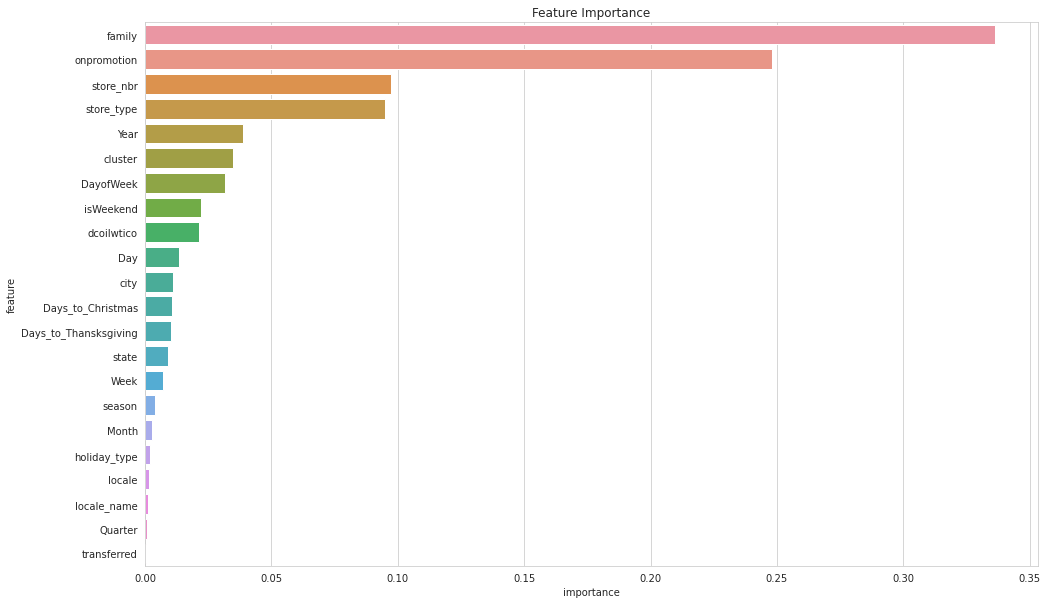

In [ ]:
#Feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(16,10))
plt.title('Feature Importance')
sns.barplot(data=importance_df, x='importance', y='feature');

In [ ]:
#Functions for tuning the hyper parameters.
def test_params(**params):  
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(X_train,y_train)
    train_rmsle = rmsle(model.predict(X_train), y_train)
    val_rmsle = rmsle(model.predict(X_test), y_test)
    return train_rmsle, val_rmsle

def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmsle, val_rmsle = test_params(**params)
        train_errors.append(train_rmsle)
        val_errors.append(val_rmsle)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSLE')
    plt.legend(['Training', 'Validation'])

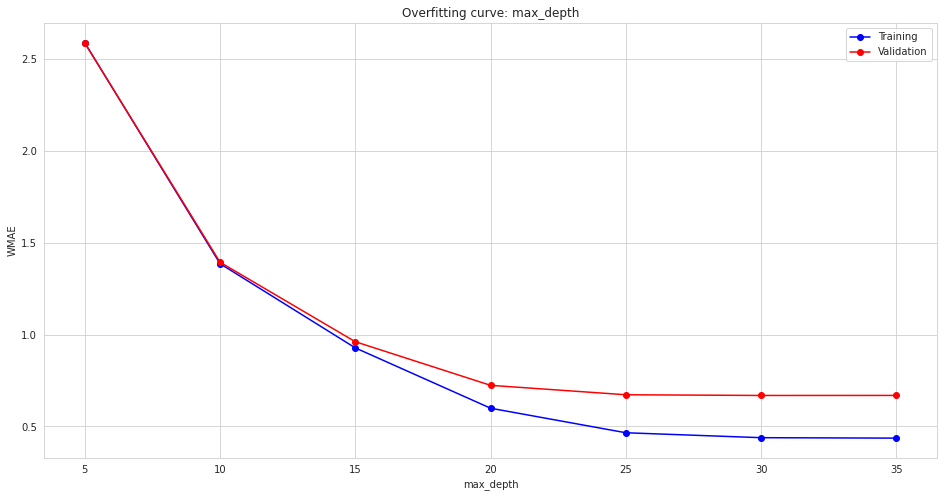

In [ ]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

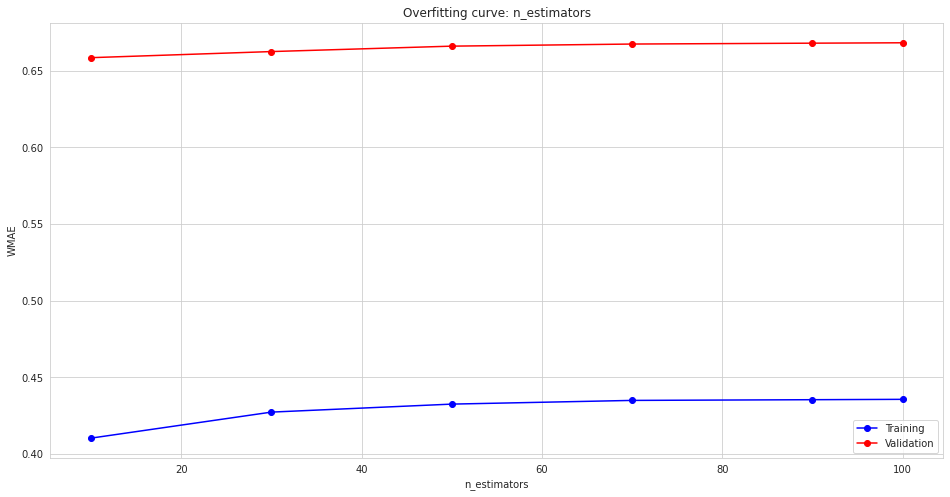

In [ ]:
test_param_and_plot('n_estimators', [10, 30, 50, 70, 90, 100])

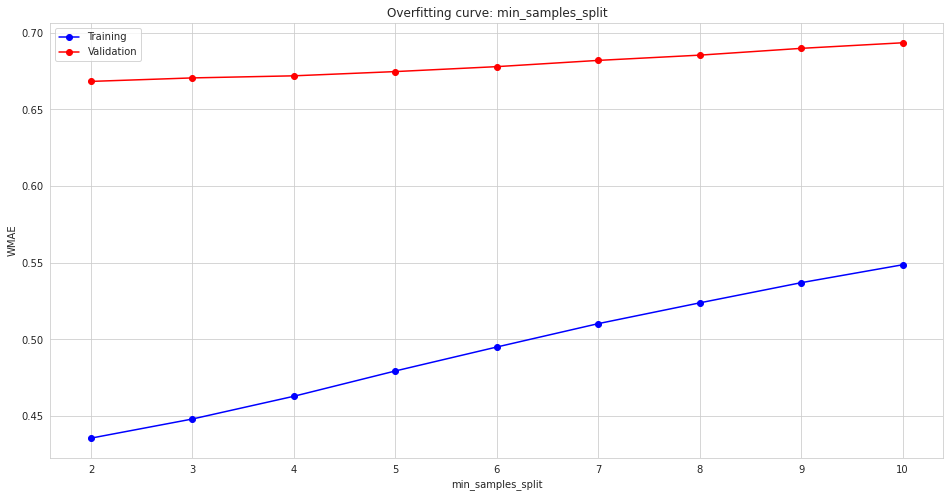

In [ ]:
test_param_and_plot('min_samples_split', [2, 3, 4, 5, 6, 7, 8, 9, 10])

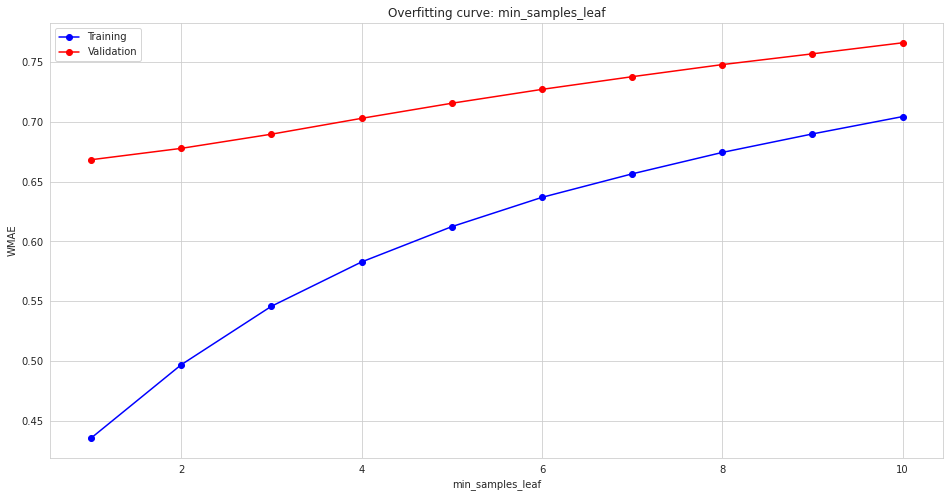

In [ ]:
test_param_and_plot('min_samples_leaf', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

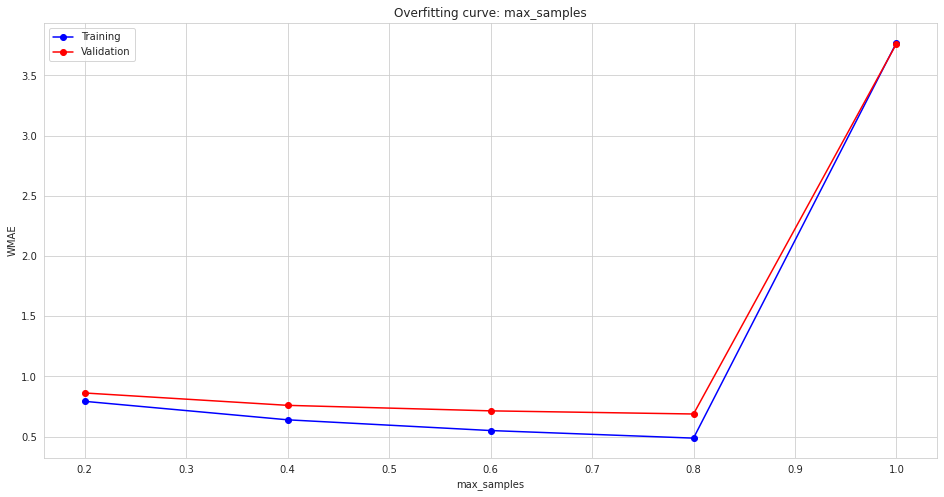

In [ ]:
test_param_and_plot('max_samples', [0.2, 0.4, 0.6, 0.8, 1])

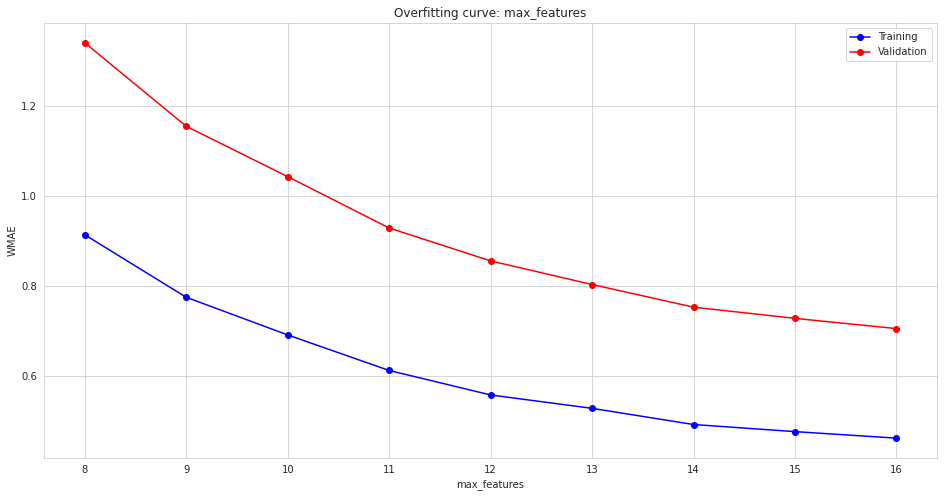

In [ ]:
test_param_and_plot('max_features', [8, 9, 10, 11, 12, 13, 14, 15, 16])

From the above testing of parameters, the follwoing values of parameters were found to be the best which minimizes the validation error.

- max_depth: 35
- n_estimators: 100
- min_samples_split: 2
- min_samples_leaf: 1
- max_samples: 0.8
- max_features: more than 16

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#Tuned model
model_tun = RandomForestRegressor(n_jobs=-1, max_depth=35, n_estimators=130, min_samples_split=2, min_samples_leaf=1, max_samples=0.80, max_features=20, random_state=123)
model_tun.fit(X_train, y_train)
train_pred = model_tun.predict(X_train)
test_pred = model_tun.predict(X_test)

#RMSLE on traing data
train_rmsle = rmsle(train_pred, y_train)
print('The RMSLE for the training set is  {}.'.format(train_rmsle))

# Compute WMAE on validation data
test_rmsle = rmsle(test_pred, y_test)
print('The RMSLE for the validation set is  {}.'.format(test_rmsle))

The RMSLE for the training set is  0.4973832235442358.
The RMSLE for the validation set is  0.6997438424768786.


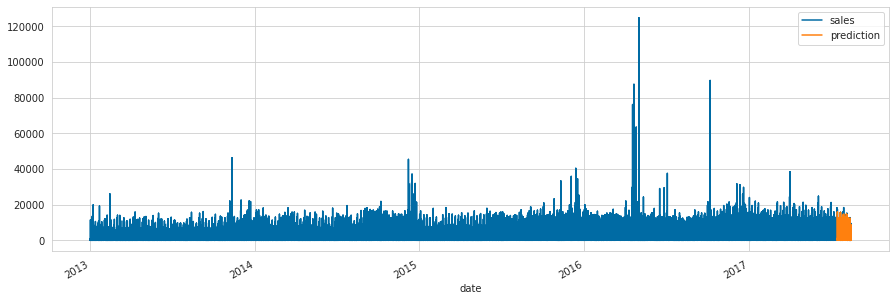

In [ ]:
df_test_model['prediction'] = (model_tun.predict(df_test_model[model_features]))
df_all = pd.concat([df_test_model, df_train_model], sort=False)
_ = df_all[['sales','prediction']].plot(figsize=(15, 5))

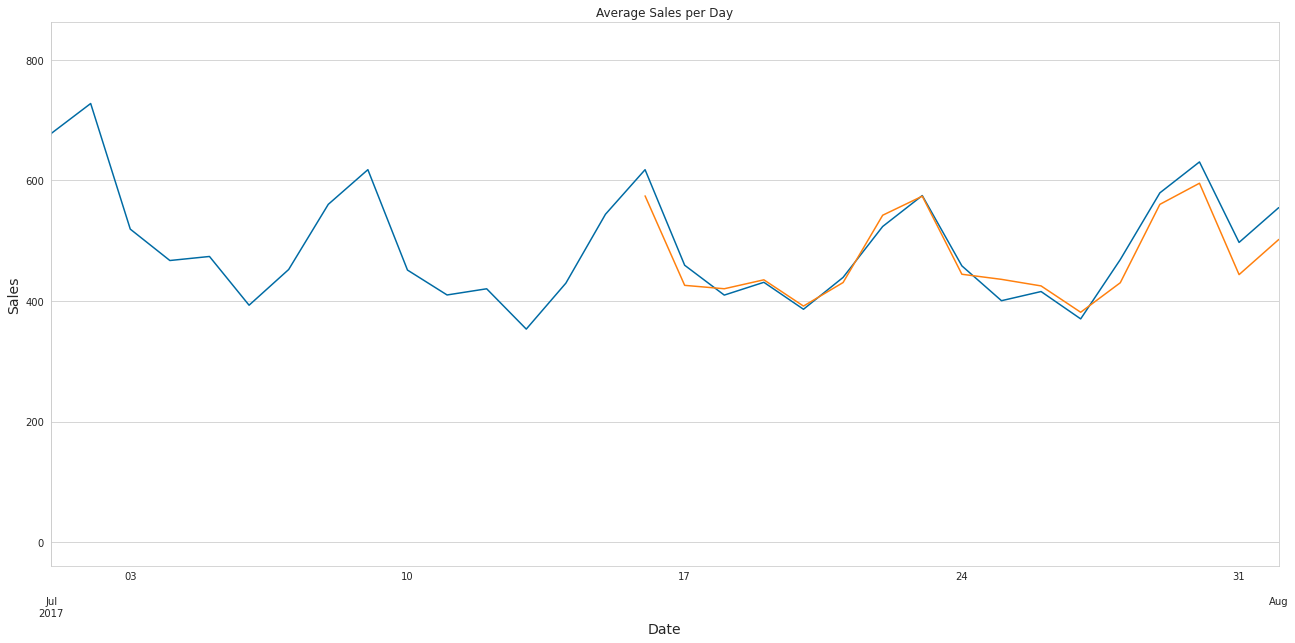

In [ ]:
#Evaluate real dan prediction data 
sales = df_all.sales.resample("D").mean()
prediction = df_all.prediction.resample("D").mean()

f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)

sales.plot(ax=ax)
prediction.plot(ax=ax)

#ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)
ax.set_title('Average Sales per Day')
ax.set_xbound(lower='2017.07.01', upper='2017.08.01')

plt.show()

In [ ]:
df_test_model[['sales','prediction']].head(10)

,sales,prediction
date,,
2017-07-16,2.000,1.838462
2017-07-16,0.000,1.130769
2017-07-16,2.000,1.146154
2017-07-16,1079.000,1306.353846
2017-07-16,0.000,0.038462
2017-07-16,121.055,162.682100
2017-07-16,9.000,7.530769
2017-07-16,231.000,332.346154
2017-07-16,325.000,347.946154


## Forecasting on test data

In [ ]:
# Making sales prediction on sales data
test['prediction'] = (model_tun.predict(test[model_features])) 
test['prediction'] = test['prediction'].astype(int)

In [ ]:
test[['id','prediction']].head(20)

,id,prediction
0,3000888,6
1,3000889,0
2,3000890,472
3,3000891,2267
4,3000892,0
5,3000893,668
6,3000894,0
7,3000895,1188
8,3000896,1059
9,3000897,343


# Conclusion

- Based on forecasting from the light gbm model that has been made, an rmsle value of 0.70 is obtained which indicates a small error. this error value is larger than the bradient boosting algorithm

- In addition, the model score obtained is very high, 93.21% so that this model can properly explain the diversity of the data and can produce accurate predictions.